# Sentiment analysis using LSTM

## Step 1: Data exploration and preprocessing

In [ ]:
import tarfile
import os
import pandas as pd
import random
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize, regexp_tokenize
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import torch
from nltk import ngrams
from nltk.probability import FreqDist
import time 
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import urllib.request
import zipfile
from torchtext.vocab import Vectors
import re
from pathlib import Path

In [ ]:
base_path = Path("sentimentAnalysisData")
filePath = base_path / "aclImdb_v1.tar.gz"
with tarfile.open(filePath, 'r:gz') as tar:
    print(tar.getnames())
    tar.extractall(path=base_path)

posFolder = base_path / "aclImdb/train/pos"
negFolder = base_path / "aclImdb/train/neg"

def loadReviews(directory, label):
    reviews = []
    for filename in os.listdir(directory):
        if filename.endswith('.txt'):
            with open(os.path.join(directory, filename), 'r', encoding='utf-8') as file:
                review = file.read()
                reviews.append((review, label))
    return reviews

negReviews = loadReviews(negFolder, 0)
posReviews = loadReviews(posFolder, 1)
allReviews = posReviews + negReviews
random.shuffle(allReviews)

texts = [review[0] for review in allReviews]
labels = [review[1] for review in allReviews]


['aclImdb', 'aclImdb/test', 'aclImdb/train', 'aclImdb/test/neg', 'aclImdb/test/pos', 'aclImdb/train/neg', 'aclImdb/train/pos', 'aclImdb/train/unsup', 'aclImdb/imdbEr.txt', 'aclImdb/imdb.vocab', 'aclImdb/README', 'aclImdb/test/labeledBow.feat', 'aclImdb/test/urls_neg.txt', 'aclImdb/test/urls_pos.txt', 'aclImdb/train/unsupBow.feat', 'aclImdb/train/labeledBow.feat', 'aclImdb/train/urls_neg.txt', 'aclImdb/train/urls_pos.txt', 'aclImdb/train/urls_unsup.txt', 'aclImdb/test/neg/127_3.txt', 'aclImdb/test/neg/126_4.txt', 'aclImdb/test/neg/125_3.txt', 'aclImdb/test/neg/124_2.txt', 'aclImdb/test/neg/123_4.txt', 'aclImdb/test/neg/122_4.txt', 'aclImdb/test/neg/121_4.txt', 'aclImdb/test/neg/120_2.txt', 'aclImdb/test/neg/119_3.txt', 'aclImdb/test/neg/118_1.txt', 'aclImdb/test/neg/117_1.txt', 'aclImdb/test/neg/116_4.txt', 'aclImdb/test/neg/115_3.txt', 'aclImdb/test/neg/114_2.txt', 'aclImdb/test/neg/113_3.txt', 'aclImdb/test/neg/112_2.txt', 'aclImdb/test/neg/111_3.txt', 'aclImdb/test/neg/110_1.txt', 'a

In [56]:
print(f"Total number of reviews is {len(allReviews)}")
print(f"Number of Positive reviews is {len(posReviews)}")
print(f"Number of Negative reviews is {len(negReviews)}")
print(f"Minimum review length is {min(len(review[0].split()) for review in allReviews)}")
print(f"Maximum review length is {max(len(review[0].split()) for review in allReviews)}") 

Total number of reviews is 25000
Number of Positive reviews is 12500
Number of Negative reviews is 12500
Minimum review length is 10
Maximum review length is 2470


In [ ]:
reviewDf = pd.DataFrame(list(zip(texts, labels)), columns=['review', 'sentiment'])
print(reviewDf.head())

                                              review  sentiment
0  I recently viewed Manufactured Landscapes at t...          0
1  This film is mesmerizing in its beauty and cre...          1
2  i think that's this is awful produced and dire...          0
3  The acting was horrible and they got both of t...          0
4  This movie proves that good acting comes from ...          0


In [ ]:

numberSamples = len(reviewDf)
print(f"Number of samples: {numberSamples}")

sentimentDistribution = reviewDf['sentiment'].value_counts(normalize=True) * 100
print(f"Class distribution:\n{sentimentDistribution}")

reviewDf['reviewLengthInWords'] = reviewDf['review'].apply(lambda x: len(x.split()))
reviewDf['reviewLengthInChars'] = reviewDf['review'].apply(len)
avgReviewLengthOfWords = reviewDf['reviewLengthInWords'].mean()
avgReviewLengthOfChars = reviewDf['reviewLengthInChars'].mean()
print(f"Average review length of words: {avgReviewLengthOfWords}")
print(f"Average review length of characters): {avgReviewLengthOfChars}")

words = set(" ".join(reviewDf['review']).split())
vocabularySize = len(words)
print(f"Vocabulary size: {vocabularySize}")

Number of samples: 25000
Class distribution:
sentiment
0    50.0
1    50.0
Name: proportion, dtype: float64
Average review length of words: 233.7872
Average review length of characters): 1325.06964
Vocabulary size: 280617


In [ ]:

reviewDf = reviewDf.dropna()

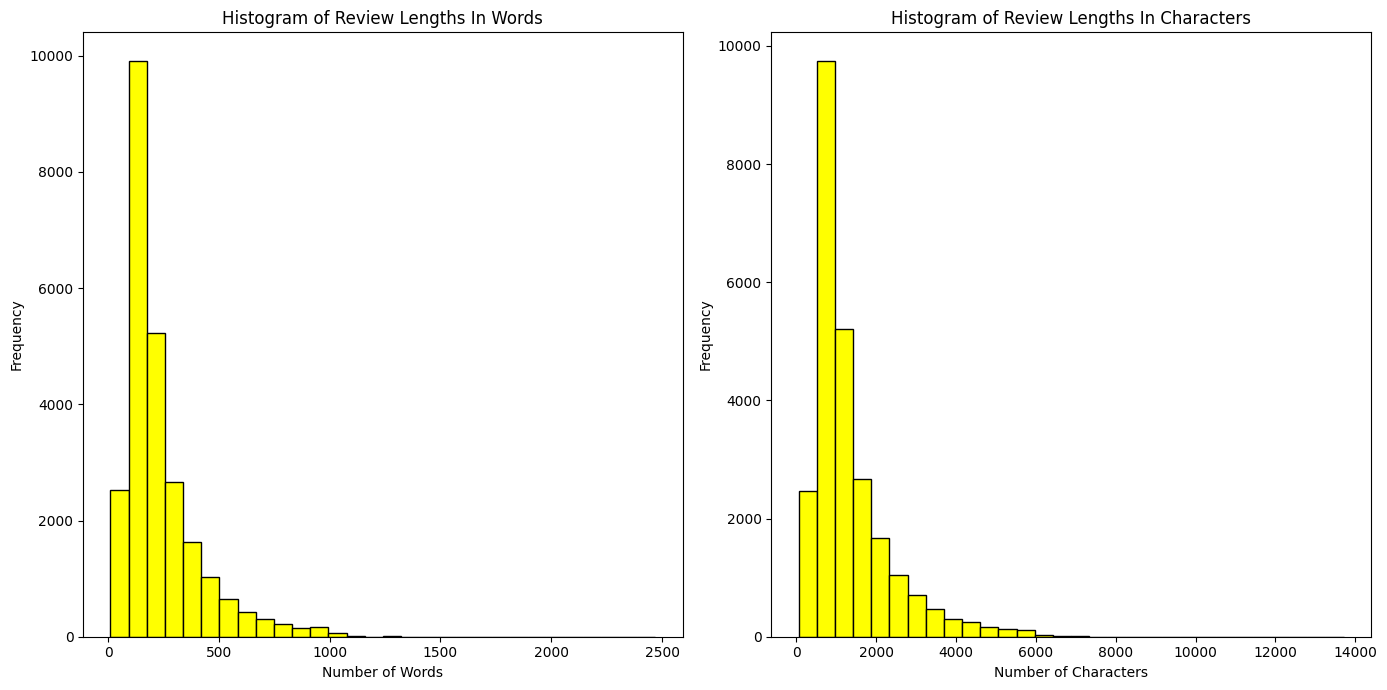

In [ ]:

plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.hist(reviewDf['reviewLengthInWords'], bins=30, color='yellow', edgecolor='black')
plt.title('Histogram of Review Lengths In Words')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(reviewDf['reviewLengthInChars'], bins=30, color='yellow', edgecolor='black')
plt.title('Histogram of Review Lengths In Characters')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

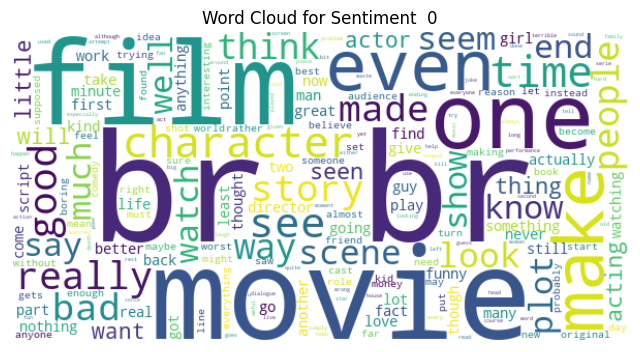

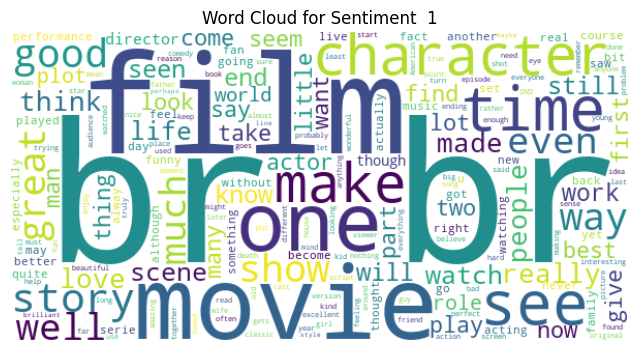

In [7]:
for item in reviewDf['sentiment'].unique():
    text = " ".join(reviewDf[reviewDf['sentiment'] == item]['review'])
    wordcloud = WordCloud(width=600, height=300, background_color='white').generate(text)    
    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for Sentiment  {item}")
    plt.show()


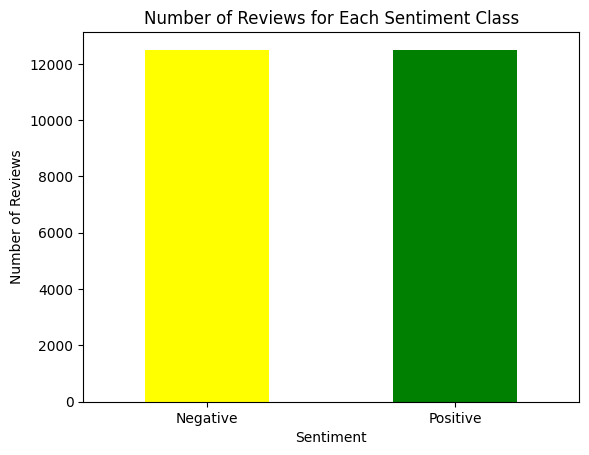

In [8]:
sentimentCount = reviewDf['sentiment'].value_counts()
sentimentCount.plot(kind='bar', color=['yellow', 'green'])
plt.title('Number of Reviews for Each Sentiment Class')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'], rotation=0)
plt.show()

In [9]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltktokenizer = word_tokenize
startTimeNltk = time.time()
nltktokenizedReviews = reviewDf['review'].apply(lambda x: nltktokenizer(x.lower()))
nltkProcessingTime = time.time() - startTimeNltk

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/devanshiverma/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/devanshiverma/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


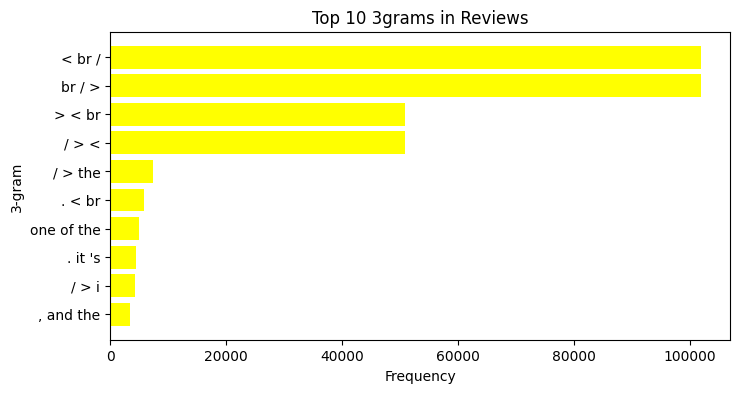

In [10]:
def extractNgrams(tokenizedReviews, n=3):
    ngramList = []
    for review in tokenizedReviews:
        ngramList.extend(list(ngrams(review, n)))
    return ngramList
threegrams = extractNgrams(nltktokenizedReviews, n=3)
threegramsFreq = FreqDist(threegrams)
mostCommon3grams = threegramsFreq.most_common(10)
mostCommon3gramsLabels, mostCommon3gramsCounts = zip(*mostCommon3grams)
mostCommon3gramsLabels = [' '.join(gram) for gram in mostCommon3gramsLabels]
plt.figure(figsize=(8, 4))
plt.barh(mostCommon3gramsLabels, mostCommon3gramsCounts, color='yellow')
plt.xlabel('Frequency')
plt.ylabel('3-gram')
plt.title('Top 10 3grams in Reviews')
plt.gca().invert_yaxis()
plt.show()

7. Data preparation

In [12]:
def removeHtmlTags(text):
    cleanText = re.sub(r'<[^>]+>', '', text)
    return cleanText
def regexTokenizer(text):
    text = removeHtmlTags(text)
    pattern = r"(<[^>]+>|[a-zA-Z0-9]+|[.,!?;])"
    return regexp_tokenize(text.lower(), pattern)
startTimeRegex = time.time()
regextokenizedReviews = reviewDf['review'].apply(lambda x: regexTokenizer(x))
regexProcessingTime = time.time() - startTimeRegex

nltkVocabulary = set([word for review in nltktokenizedReviews for word in review])
regexVocabulary = set([word for review in regextokenizedReviews for word in review])

print(f"NLTK Tokenizer Processing Time: {nltkProcessingTime:.4f} seconds")
print(f"Regex Tokenizer Processing Time: {regexProcessingTime:.4f} seconds")

print(f"NLTK Vocabulary Size: {len(nltkVocabulary)}")
print(f"Regex Vocabulary Size: {len(regexVocabulary)}")

print("\nSample of NLTK tokenized reviews:")
print(nltktokenizedReviews.head())
print("\nSample of Regex tokenized reviews:")
print(regextokenizedReviews.head())


NLTK Tokenizer Processing Time: 11.2909 seconds
Regex Tokenizer Processing Time: 0.6228 seconds
NLTK Vocabulary Size: 111827
Regex Vocabulary Size: 75543

Sample of NLTK tokenized reviews:
0    [i, recently, viewed, manufactured, landscapes...
1    [this, film, is, mesmerizing, in, its, beauty,...
2    [i, think, that, 's, this, is, awful, produced...
3    [the, acting, was, horrible, and, they, got, b...
4    [this, movie, proves, that, good, acting, come...
Name: review, dtype: object

Sample of Regex tokenized reviews:
0    [i, recently, viewed, manufactured, landscapes...
1    [this, film, is, mesmerizing, in, its, beauty,...
2    [i, think, that, s, this, is, awful, produced,...
3    [the, acting, was, horrible, and, they, got, b...
4    [this, movie, proves, that, good, acting, come...
Name: review, dtype: object


From the three-gram graph and wordCloud it was observed that there is html tags that are in the input, so using regex tokenizer to capture this html tags and treat them as one entity , reduced the processing time drastically also the size of vocabulary is sufficient for sentiment classification , therefore choosing regex tokenizer

In [13]:
reviewDf = reviewDf[['review', 'sentiment']]
trainData, valTestData = train_test_split(reviewDf, test_size=0.3, random_state=42)
valData, testData = train_test_split(valTestData, test_size=0.5, random_state=42)

trainData['tokenizedReview'] = trainData['review'].apply(lambda x: regexTokenizer(x))
valData['tokenizedReview'] = valData['review'].apply(lambda x: regexTokenizer(x))
testData['tokenizedReview'] = testData['review'].apply(lambda x: regexTokenizer(x))


In [14]:
allTokens = [token for review in trainData['tokenizedReview'] for token in review]
vocab = {token: idx for idx, token in enumerate(sorted(set(allTokens)), 1)}
vocab['<PAD>'] = 0
def textToNumSequence(tokens, vocab):
    return [vocab.get(token, vocab['<PAD>']) for token in tokens]

trainData['numericalReview'] = trainData['tokenizedReview'].apply(lambda x: textToNumSequence(x, vocab))
valData['numericalReview'] = valData['tokenizedReview'].apply(lambda x: textToNumSequence(x, vocab))
testData['numericalReview'] = testData['tokenizedReview'].apply(lambda x: textToNumSequence(x, vocab))

In [15]:

maxLength = int(np.percentile([len(review) for review in trainData['numericalReview']], 95))
def padSequenceToLength(sequence, maxLength):
    if len(sequence) < maxLength:
        return sequence + [vocab['<PAD>']] * (maxLength - len(sequence))
    else:
        return sequence[:maxLength]

trainData['paddedReview'] = trainData['numericalReview'].apply(lambda x: padSequenceToLength(x, maxLength))
valData['paddedReview'] = valData['numericalReview'].apply(lambda x: padSequenceToLength(x, maxLength))
testData['paddedReview'] = testData['numericalReview'].apply(lambda x: padSequenceToLength(x, maxLength))


8. Split dataset into train, validation, and test sets

In [17]:

trainData = trainData[:int(len(trainData) * 0.5)]
valData = valData[:int(len(valData) * 0.5)]
testData = testData[:int(len(testData) * 0.5)]


In [18]:
def createTensorDataset(data):
    inputs = torch.tensor(list(data['paddedReview']))
    labels = torch.tensor(list(data['sentiment']))
    return TensorDataset(inputs, labels)

trainDataset = createTensorDataset(trainData)
valDataset = createTensorDataset(valData)
testDataset = createTensorDataset(testData)

trainLoader = DataLoader(trainDataset, batch_size=64, shuffle=True)
valLoader = DataLoader(valDataset, batch_size=64, shuffle=False)
testLoader = DataLoader(testDataset, batch_size=64, shuffle=False)

print(f"Training data size: {len(trainData)}")
print(f"Validation data size: {len(valData)}")
print(f"Test data size: {len(testData)}")

Training data size: 8750
Validation data size: 1875
Test data size: 1875


## Step 2: Baseline LSTM Model

1. Build an LSTM model

In [20]:
class BaseLSTM(nn.Module):
    def __init__(self, vocabSize, embedDim, hiddenUnits, dropoutRate):
        super(BaseLSTM, self).__init__()
        self.embedding = nn.Embedding(vocabSize, embedDim)
        self.lstm1 = nn.LSTM(embedDim, hiddenUnits, batch_first=True, dropout=dropoutRate, bidirectional=False)
        self.lstm2 = nn.LSTM(hiddenUnits, hiddenUnits, batch_first=True, dropout=dropoutRate, bidirectional=False)
        self.lstm3 = nn.LSTM(hiddenUnits, hiddenUnits, batch_first=True, dropout=dropoutRate, bidirectional=False)
        self.dropout = nn.Dropout(dropoutRate)
        self.fc = nn.Linear(hiddenUnits, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.embedding(x)
        lstmOut1, _ = self.lstm1(x)
        lstmOut1 = self.dropout(lstmOut1)
        lstmOut2, _ = self.lstm2(lstmOut1)
        lstmOut2 = self.dropout(lstmOut2)
        lstmOut3, _ = self.lstm3(lstmOut2)
        lstmOut3 = self.dropout(lstmOut3)
        x = lstmOut3[:, -1, :]
        x = self.fc(x)
        x = self.sigmoid(x)
        return x



2. Train your model

In [22]:
vocabSize = len(vocab)
embedDim = 50
hiddenUnits = 128
dropoutRate = 0.5
model = BaseLSTM(vocabSize, embedDim, hiddenUnits, dropoutRate)
print(summary(model))
lossFn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Layer (type:depth-idx)                   Param #
BaseLSTM                                 --
├─Embedding: 1-1                         3,260,200
├─LSTM: 1-2                              92,160
├─LSTM: 1-3                              132,096
├─LSTM: 1-4                              132,096
├─Dropout: 1-5                           --
├─Linear: 1-6                            129
├─Sigmoid: 1-7                           --
Total params: 3,616,681
Trainable params: 3,616,681
Non-trainable params: 0


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [23]:
def plotMetrics(trainLosses, valLosses, trainAccuracies, valAccuracies, epochs):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), trainLosses, label="Train Loss")
    plt.plot(range(epochs), valLosses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training vs Validation Loss")
    
    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), trainAccuracies, label="Train Accuracy")
    plt.plot(range(epochs), valAccuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy over Epochs")
    
    plt.tight_layout()
    plt.show()

In [24]:
def trainModel(model, trainLoader, valLoader, optimizer, lossFn, epochs=10):
    trainLosses = []
    valLosses = []
    trainAccuracies = []
    valAccuracies = []
    
    for epoch in range(epochs):
        model.train()
        runningLoss = 0.0
        correctTrain = 0
        totalTrain = 0
        for inputs, labels in trainLoader:
            optimizer.zero_grad()
            outputs = model(inputs)
            labels = labels.float().view(-1, 1)
            loss = lossFn(outputs, labels)
            loss.backward()
            optimizer.step()
            runningLoss += loss.item()

            preds = (outputs > 0.5).float()
            correctTrain += (preds == labels).sum().item()
            totalTrain += labels.size(0)

        trainAccuracies.append((correctTrain / totalTrain) * 100)
        trainLosses.append(runningLoss / len(trainLoader))
        
        model.eval()
        valLoss = 0.0
        correctVal = 0
        totalVal = 0
        allPreds = []
        allLabels = []
        with torch.no_grad():
            for inputs, labels in valLoader:
                outputs = model(inputs)
                labels = labels.float().view(-1, 1)
                loss = lossFn(outputs, labels)
                valLoss += loss.item()

                preds = (outputs > 0.5).float()
                correctVal += (preds == labels).sum().item()
                totalVal += labels.size(0)

                allPreds.extend(preds.cpu().numpy())
                allLabels.extend(labels.cpu().numpy())

        valAccuracies.append((correctVal / totalVal) * 100)
        valLosses.append(valLoss / len(valLoader))
        
        valAccuracy = accuracy_score(allLabels, allPreds)
        
        print(f"Epoch {epoch + 1}, Train Loss: {trainLosses[-1]:.4f}, Train Accuracy: {trainAccuracies[-1]:.4f}%, Val Loss: {valLosses[-1]:.4f}, Val Accuracy: {valAccuracy * 100:.4f}%")

    return trainLosses, valLosses, trainAccuracies, valAccuracies, epochs, valAccuracy


In [25]:
trainLossesBase, valLossesBase, trainAccuraciesBase, valAccuraciesBase, epochsBase, valAccuracyBase = trainModel(model, trainLoader, valLoader, optimizer, lossFn, epochs=5)

Epoch 1, Train Loss: 0.6939, Train Accuracy: 50.4457%, Val Loss: 0.6954, Val Accuracy: 49.2267%
Epoch 2, Train Loss: 0.6937, Train Accuracy: 50.7200%, Val Loss: 0.6934, Val Accuracy: 49.2267%
Epoch 3, Train Loss: 0.6932, Train Accuracy: 50.2629%, Val Loss: 0.6932, Val Accuracy: 50.8267%
Epoch 4, Train Loss: 0.6924, Train Accuracy: 50.1143%, Val Loss: 0.6934, Val Accuracy: 49.2267%
Epoch 5, Train Loss: 0.6902, Train Accuracy: 50.8229%, Val Loss: 0.6976, Val Accuracy: 50.7200%


In [26]:


def manualTuning(trainLoader, valLoader, lossFn, epochs=10):
    dropoutRates = [0.2, 0.5, 0.7]
    bestDropoutRate = None
    bestValAccuracy = 0
    hiddenUnits = 128

    for dropoutRate in dropoutRates:
        print(f"Training with Dropout Rate: {dropoutRate}")
        model = BaseLSTM(vocabSize, embedDim, hiddenUnits, dropoutRate)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        trainLosses, valLosses, trainAccuracies, valAccuracies, epochs, valAccuracy = trainModel(
            model, trainLoader, valLoader, optimizer, lossFn, epochs=epochs)
        
        if valAccuracy > bestValAccuracy:
            bestValAccuracy = valAccuracy
            bestDropoutRate = dropoutRate

    print(f"Best Dropout Rate: {bestDropoutRate} with Val Accuracy: {bestValAccuracy}")

    hiddenUnits = [64, 128, 256]
    bestHiddenUnits = None
    bestCombinationAccuracy = 0
    bestCombinationLoss = None
    
    for hiddenUnit in hiddenUnits:
        print(f"Training with Hidden Units: {hiddenUnit} and Dropout Rate: {bestDropoutRate}")
        model = BaseLSTM(vocabSize, embedDim, hiddenUnit, bestDropoutRate)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        trainLosses, valLosses, trainAccuracies, valAccuracies, epochs, valAccuracy = trainModel(
            model, trainLoader, valLoader, optimizer, lossFn, epochs=epochs)
        
        if valAccuracy > bestCombinationAccuracy:
            bestCombinationAccuracy = valAccuracy
            bestHiddenUnits = hiddenUnit
            bestCombinationLoss = valLosses[-1]

    print(f"Best Hidden Units: {bestHiddenUnits} with Val Accuracy: {bestCombinationAccuracy}")

    return  bestDropoutRate, bestHiddenUnits, bestCombinationAccuracy, bestCombinationLoss

bestBaseDropoutRate,bestBaseHiddenUnits,bestBasevalAccuracy,bestbasevalLoss = manualTuning(trainLoader, valLoader, lossFn, epochs=5)
print("Best Dropout Found:", bestBaseDropoutRate)
print("Best HiddenUnits Found:", bestBaseHiddenUnits)


Training with Dropout Rate: 0.2


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1, Train Loss: 0.6937, Train Accuracy: 50.6286%, Val Loss: 0.6930, Val Accuracy: 50.8267%
Epoch 2, Train Loss: 0.6934, Train Accuracy: 49.5200%, Val Loss: 0.6949, Val Accuracy: 50.8800%
Epoch 3, Train Loss: 0.6931, Train Accuracy: 50.2057%, Val Loss: 0.6934, Val Accuracy: 50.8267%
Epoch 4, Train Loss: 0.6932, Train Accuracy: 49.9429%, Val Loss: 0.6931, Val Accuracy: 50.7733%
Epoch 5, Train Loss: 0.6928, Train Accuracy: 50.5829%, Val Loss: 0.6935, Val Accuracy: 50.9333%
Training with Dropout Rate: 0.5


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1, Train Loss: 0.6938, Train Accuracy: 49.7486%, Val Loss: 0.6937, Val Accuracy: 49.2267%
Epoch 2, Train Loss: 0.6930, Train Accuracy: 50.3314%, Val Loss: 0.6946, Val Accuracy: 49.2267%
Epoch 3, Train Loss: 0.6925, Train Accuracy: 51.1200%, Val Loss: 0.6928, Val Accuracy: 51.3067%
Epoch 4, Train Loss: 0.6908, Train Accuracy: 50.7200%, Val Loss: 0.6972, Val Accuracy: 51.1467%
Epoch 5, Train Loss: 0.6874, Train Accuracy: 51.2114%, Val Loss: 0.6989, Val Accuracy: 50.7733%
Training with Dropout Rate: 0.7


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1, Train Loss: 0.6943, Train Accuracy: 49.6686%, Val Loss: 0.6941, Val Accuracy: 49.2267%
Epoch 2, Train Loss: 0.6937, Train Accuracy: 50.1943%, Val Loss: 0.6932, Val Accuracy: 50.8800%
Epoch 3, Train Loss: 0.6938, Train Accuracy: 50.2629%, Val Loss: 0.6933, Val Accuracy: 49.2267%
Epoch 4, Train Loss: 0.6929, Train Accuracy: 50.1486%, Val Loss: 0.6943, Val Accuracy: 49.2267%
Epoch 5, Train Loss: 0.6920, Train Accuracy: 50.2057%, Val Loss: 0.6982, Val Accuracy: 49.1733%
Best Dropout Rate: 0.2 with Val Accuracy: 0.5093333333333333
Training with Hidden Units: 64 and Dropout Rate: 0.2


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1, Train Loss: 0.6934, Train Accuracy: 50.2971%, Val Loss: 0.6931, Val Accuracy: 50.8800%
Epoch 2, Train Loss: 0.6930, Train Accuracy: 50.9600%, Val Loss: 0.6932, Val Accuracy: 50.8800%
Epoch 3, Train Loss: 0.6926, Train Accuracy: 50.0571%, Val Loss: 0.6945, Val Accuracy: 49.2267%
Epoch 4, Train Loss: 0.6898, Train Accuracy: 49.6457%, Val Loss: 0.6938, Val Accuracy: 49.1733%
Epoch 5, Train Loss: 0.6855, Train Accuracy: 51.7029%, Val Loss: 0.6999, Val Accuracy: 50.8800%
Training with Hidden Units: 128 and Dropout Rate: 0.2


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1, Train Loss: 0.6936, Train Accuracy: 50.4571%, Val Loss: 0.6934, Val Accuracy: 49.2267%
Epoch 2, Train Loss: 0.6930, Train Accuracy: 49.2914%, Val Loss: 0.6932, Val Accuracy: 49.2267%
Epoch 3, Train Loss: 0.6923, Train Accuracy: 50.8457%, Val Loss: 0.6933, Val Accuracy: 50.7733%
Epoch 4, Train Loss: 0.6907, Train Accuracy: 50.6057%, Val Loss: 0.6936, Val Accuracy: 50.8267%
Epoch 5, Train Loss: 0.6869, Train Accuracy: 50.4343%, Val Loss: 0.6956, Val Accuracy: 51.0400%
Training with Hidden Units: 256 and Dropout Rate: 0.2


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1, Train Loss: 0.6939, Train Accuracy: 50.1257%, Val Loss: 0.6934, Val Accuracy: 49.2267%
Epoch 2, Train Loss: 0.6933, Train Accuracy: 49.7371%, Val Loss: 0.6931, Val Accuracy: 49.2267%
Epoch 3, Train Loss: 0.6929, Train Accuracy: 50.1600%, Val Loss: 0.6932, Val Accuracy: 49.2267%
Epoch 4, Train Loss: 0.6912, Train Accuracy: 51.0971%, Val Loss: 0.6928, Val Accuracy: 51.2000%
Epoch 5, Train Loss: 0.6884, Train Accuracy: 50.9829%, Val Loss: 0.6945, Val Accuracy: 49.2267%
Best Hidden Units: 128 with Val Accuracy: 0.5104
Best Dropout Found: 0.2
Best HiddenUnits Found: 128


In [27]:
bestBaseModel = BaseLSTM(vocabSize, embedDim, bestBaseHiddenUnits, bestBaseDropoutRate)
trainLossesBestBase, valLossesBestBase, trainAccuraciesBestBase, valAccuraciesBestBase, epochsBestBase, valAccuracyBestBase = trainModel(bestBaseModel, trainLoader, valLoader, optimizer, lossFn, epochs=5)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1, Train Loss: 0.6943, Train Accuracy: 49.6114%, Val Loss: 0.6934, Val Accuracy: 50.7733%
Epoch 2, Train Loss: 0.6944, Train Accuracy: 49.6114%, Val Loss: 0.6934, Val Accuracy: 50.7733%
Epoch 3, Train Loss: 0.6943, Train Accuracy: 49.6114%, Val Loss: 0.6934, Val Accuracy: 50.7733%
Epoch 4, Train Loss: 0.6943, Train Accuracy: 49.6114%, Val Loss: 0.6934, Val Accuracy: 50.7733%
Epoch 5, Train Loss: 0.6944, Train Accuracy: 49.6114%, Val Loss: 0.6934, Val Accuracy: 50.7733%


Base Model Best Validation Acuuracy is:  0.5077333333333334


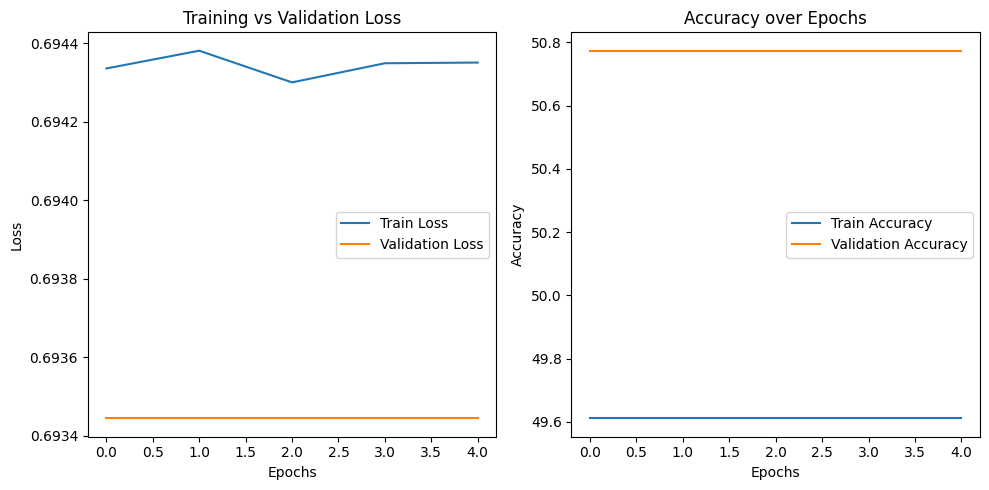

In [58]:
print("Base Model Best Validation Acuuracy is: " , valAccuracyBestBase)
plotMetrics(trainLossesBestBase, valLossesBestBase, trainAccuraciesBestBase, valAccuraciesBestBase, epochsBestBase)

3. Evaluation and analysis

In [30]:

def evaluateModel(model, testLoader, lossFn):
    model.eval()
    testLoss = 0.0
    correctTest = 0
    allPreds = []
    allLabels = []

    with torch.no_grad():
        for inputs, labels in testLoader:
            outputs = model(inputs)
            labels = labels.float().view(-1, 1)
            loss = lossFn(outputs, labels)
            testLoss += loss.item()

            preds = (outputs > 0.5).float()
            correctTest += (preds == labels).sum().item()
            allLabels.extend(labels.cpu().numpy())
            allPreds.extend(preds.cpu().numpy())
            

    accuracy = accuracy_score(allLabels, allPreds)
    precision = precision_score(allLabels, allPreds)
    recall = recall_score(allLabels, allPreds)
    f1 = f1_score(allLabels, allPreds)
    avgTestLoss = testLoss / len(testLoader)

    print(f"Test Loss: {avgTestLoss:.4f}, Test Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

    return accuracy, precision, recall, f1, avgTestLoss, allLabels, allPreds

def plotConfMatrix(allLabels, allPreds):
    cm = confusion_matrix(allLabels, allPreds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Sentiment 0", "Sentiment 1"], yticklabels=["Sentiment 0", "Sentiment 1"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()


Test Loss: 0.6944, Test Accuracy: 0.4949
Precision: 0.0000, Recall: 0.0000, F1-score: 0.0000


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


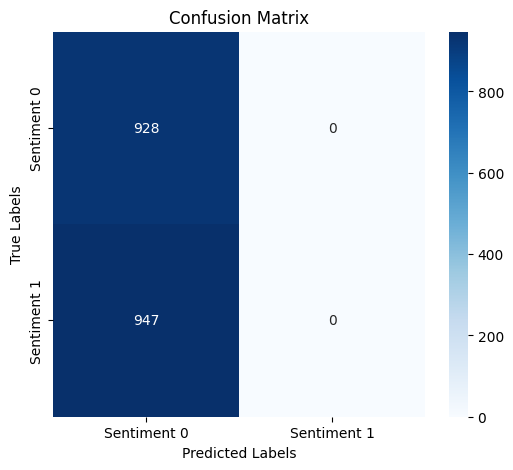

In [31]:
testAccuracy, testPrecision, testRecall, testF1, testLoss, allLabels, allPreds = evaluateModel(bestBaseModel, testLoader, lossFn)
plotConfMatrix(allLabels, allPreds)

## Step 3: Improved LSTM Model

In [35]:

class ImprovedLSTM(nn.Module):
    def __init__(self, vocabSize, embedDim, hiddenUnits, dropoutRate, pretrainedEmbeddings):
        super(ImprovedLSTM, self).__init__()

        if pretrainedEmbeddings is not None:
            self.embedding = nn.Embedding.from_pretrained(pretrainedEmbeddings, freeze=False)
        else:
            self.embedding = nn.Embedding(vocabSize, embedDim)

        self.lstm1 = nn.LSTM(embedDim, hiddenUnits, batch_first=True, dropout=dropoutRate, bidirectional=True)
        self.lstm2 = nn.LSTM(2 * hiddenUnits, hiddenUnits, batch_first=True, dropout=dropoutRate, bidirectional=True)
        self.lstm3 = nn.LSTM(2 * hiddenUnits, hiddenUnits, batch_first=True, dropout=dropoutRate, bidirectional=True)

        self.dropout = nn.Dropout(dropoutRate)
        self.fc = nn.Linear(2 * hiddenUnits, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.embedding(x)

        lstmOut1, _ = self.lstm1(x)
        lstmOut1 = self.dropout(lstmOut1)

        lstmOut2, _ = self.lstm2(lstmOut1)
        lstmOut2 = self.dropout(lstmOut2)

        lstmOut3, _ = self.lstm3(lstmOut2)
        lstmOut3 = self.dropout(lstmOut3)

        x = lstmOut3[:, -1, :]
        x = self.fc(x)
        x = self.sigmoid(x)

        return x


In [36]:
Improvedmodel = ImprovedLSTM(vocabSize, embedDim, 128, 0.5, pretrainedEmbeddings=gloveVectors.vectors)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


3. Follow the same training and evaluation procedures

In [38]:
trainLossesImprovedmodel, valLossesImprovedmodel, trainAccuraciesImprovedmodel, valAccuraciesImprovedmodel, epochsImprovedmodel, valAccuracyImprovedmodel = trainModel(Improvedmodel, trainLoader, valLoader, optimizer, lossFn, epochs=5)

Epoch 1, Train Loss: 0.6935, Train Accuracy: 49.8057%, Val Loss: 0.6931, Val Accuracy: 50.7733%
Epoch 2, Train Loss: 0.6935, Train Accuracy: 49.5886%, Val Loss: 0.6931, Val Accuracy: 50.7733%
Epoch 3, Train Loss: 0.6935, Train Accuracy: 49.8171%, Val Loss: 0.6931, Val Accuracy: 50.7733%
Epoch 4, Train Loss: 0.6936, Train Accuracy: 49.6800%, Val Loss: 0.6931, Val Accuracy: 50.7733%
Epoch 5, Train Loss: 0.6935, Train Accuracy: 49.6800%, Val Loss: 0.6931, Val Accuracy: 50.7733%


In [39]:


def manualTuningImproved(trainLoader, valLoader, lossFn, epochs=10):
    dropoutRates = [0.2, 0.5, 0.7]
    bestDropoutRate = None
    bestValAccuracy = 0
    hiddenUnits = 128

    for dropoutRate in dropoutRates:
        print(f"Training with Dropout Rate: {dropoutRate}")
        model = ImprovedLSTM(vocabSize, embedDim, hiddenUnits, dropoutRate, pretrainedEmbeddings=gloveVectors.vectors)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        trainLosses, valLosses, trainAccuracies, valAccuracies, epochs, valAccuracy = trainModel(
            model, trainLoader, valLoader, optimizer, lossFn, epochs=epochs)
        
        if valAccuracy > bestValAccuracy:
            bestValAccuracy = valAccuracy
            bestDropoutRate = dropoutRate

    print(f"Best Dropout Rate: {bestDropoutRate} with Val Accuracy: {bestValAccuracy}")

    hiddenUnits = [64, 128, 256]
    bestHiddenUnits = None
    bestCombinationAccuracy = 0
    bestCombinationLoss = None
    
    for hiddenUnit in hiddenUnits:
        print(f"Training with Hidden Units: {hiddenUnit} and Dropout Rate: {bestDropoutRate}")
        model = ImprovedLSTM(vocabSize, embedDim, hiddenUnit, bestDropoutRate, pretrainedEmbeddings=gloveVectors.vectors)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        trainLosses, valLosses, trainAccuracies, valAccuracies, epochs, valAccuracy = trainModel(
            model, trainLoader, valLoader, optimizer, lossFn, epochs=epochs)
        
        if valAccuracy > bestCombinationAccuracy:
            bestCombinationAccuracy = valAccuracy
            bestHiddenUnits = hiddenUnit
            bestCombinationLoss = valLosses[-1]

    print(f"Best Hidden Units: {bestHiddenUnits} with Val Accuracy: {bestCombinationAccuracy}")

    return  bestDropoutRate, bestHiddenUnits, bestCombinationAccuracy, bestCombinationLoss



In [40]:
bestDropoutRateImproved,bestHiddenUnitsImproved,bestvalAccuracyImproved,bestvalLossImproved = manualTuningImproved(trainLoader, valLoader, lossFn, epochs=5)
print("Best Improved Dropout Found:", bestDropoutRateImproved)
print("Best Improved HiddenUnits Found:", bestHiddenUnitsImproved)

Training with Dropout Rate: 0.2


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1, Train Loss: 0.6934, Train Accuracy: 50.6857%, Val Loss: 0.6930, Val Accuracy: 50.8800%
Epoch 2, Train Loss: 0.6931, Train Accuracy: 50.0686%, Val Loss: 0.6929, Val Accuracy: 51.0933%
Epoch 3, Train Loss: 0.6916, Train Accuracy: 50.0571%, Val Loss: 0.6984, Val Accuracy: 49.2267%
Epoch 4, Train Loss: 0.6878, Train Accuracy: 50.3886%, Val Loss: 0.7054, Val Accuracy: 51.3600%
Epoch 5, Train Loss: 0.6862, Train Accuracy: 51.5086%, Val Loss: 0.7095, Val Accuracy: 49.1733%
Training with Dropout Rate: 0.5


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1, Train Loss: 0.6933, Train Accuracy: 50.3543%, Val Loss: 0.6944, Val Accuracy: 49.2267%
Epoch 2, Train Loss: 0.6891, Train Accuracy: 51.1314%, Val Loss: 0.6944, Val Accuracy: 49.5467%
Epoch 3, Train Loss: 0.6826, Train Accuracy: 52.6971%, Val Loss: 0.6989, Val Accuracy: 49.8133%
Epoch 4, Train Loss: 0.6734, Train Accuracy: 51.4629%, Val Loss: 0.7039, Val Accuracy: 51.4133%
Epoch 5, Train Loss: 0.6687, Train Accuracy: 51.7371%, Val Loss: 0.7263, Val Accuracy: 49.7067%
Training with Dropout Rate: 0.7


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1, Train Loss: 0.6941, Train Accuracy: 50.6514%, Val Loss: 0.6929, Val Accuracy: 50.8800%
Epoch 2, Train Loss: 0.6876, Train Accuracy: 51.4286%, Val Loss: 0.7022, Val Accuracy: 51.0933%
Epoch 3, Train Loss: 0.6761, Train Accuracy: 52.9714%, Val Loss: 0.7152, Val Accuracy: 49.3333%
Epoch 4, Train Loss: 0.6672, Train Accuracy: 51.8857%, Val Loss: 0.7450, Val Accuracy: 51.3067%
Epoch 5, Train Loss: 0.6630, Train Accuracy: 52.2057%, Val Loss: 0.7372, Val Accuracy: 51.3067%
Best Dropout Rate: 0.7 with Val Accuracy: 0.5130666666666667
Training with Hidden Units: 64 and Dropout Rate: 0.7


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1, Train Loss: 0.6943, Train Accuracy: 49.5886%, Val Loss: 0.6948, Val Accuracy: 49.2267%
Epoch 2, Train Loss: 0.6862, Train Accuracy: 50.9486%, Val Loss: 0.6959, Val Accuracy: 51.1467%
Epoch 3, Train Loss: 0.6753, Train Accuracy: 52.2286%, Val Loss: 0.7079, Val Accuracy: 49.6533%
Epoch 4, Train Loss: 0.6683, Train Accuracy: 52.6057%, Val Loss: 0.7389, Val Accuracy: 49.4400%
Epoch 5, Train Loss: 0.6589, Train Accuracy: 53.2800%, Val Loss: 0.7369, Val Accuracy: 51.0933%
Training with Hidden Units: 128 and Dropout Rate: 0.7


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1, Train Loss: 0.6933, Train Accuracy: 51.1086%, Val Loss: 0.6961, Val Accuracy: 49.2267%
Epoch 2, Train Loss: 0.6722, Train Accuracy: 51.6000%, Val Loss: 0.7382, Val Accuracy: 49.3333%
Epoch 3, Train Loss: 0.6651, Train Accuracy: 52.5257%, Val Loss: 0.7283, Val Accuracy: 51.0933%
Epoch 4, Train Loss: 0.6630, Train Accuracy: 52.6743%, Val Loss: 0.7134, Val Accuracy: 51.5733%
Epoch 5, Train Loss: 0.6571, Train Accuracy: 52.9371%, Val Loss: 0.7529, Val Accuracy: 51.3600%
Training with Hidden Units: 256 and Dropout Rate: 0.7


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1, Train Loss: 0.6894, Train Accuracy: 50.7543%, Val Loss: 0.7249, Val Accuracy: 51.5200%
Epoch 2, Train Loss: 0.6868, Train Accuracy: 51.6686%, Val Loss: 0.7114, Val Accuracy: 49.7600%
Epoch 3, Train Loss: 0.6666, Train Accuracy: 55.3029%, Val Loss: 0.7229, Val Accuracy: 54.2400%
Epoch 4, Train Loss: 0.6658, Train Accuracy: 53.7257%, Val Loss: 0.7304, Val Accuracy: 51.1467%
Epoch 5, Train Loss: 0.6637, Train Accuracy: 53.0857%, Val Loss: 0.7295, Val Accuracy: 56.0533%
Best Hidden Units: 256 with Val Accuracy: 0.5605333333333333
Best Improved Dropout Found: 0.7
Best Improved HiddenUnits Found: 256


In [48]:
bestImprovedModel = ImprovedLSTM(vocabSize, embedDim, hiddenUnits=bestHiddenUnitsImproved, dropoutRate=bestDropoutRateImproved, pretrainedEmbeddings=gloveVectors.vectors)
trainLossesBestImproved, valLossesBestImproved, trainAccuraciesBestImproved, valAccuraciesBestImproved, epochsBestImproved, valAccuracyBestImproved = trainModel(bestImprovedModel, trainLoader, valLoader, optimizer, lossFn, epochs=5)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1, Train Loss: 0.6933, Train Accuracy: 49.3486%, Val Loss: 0.6932, Val Accuracy: 49.4400%
Epoch 2, Train Loss: 0.6931, Train Accuracy: 50.2629%, Val Loss: 0.6932, Val Accuracy: 49.4400%
Epoch 3, Train Loss: 0.6933, Train Accuracy: 49.3143%, Val Loss: 0.6932, Val Accuracy: 49.4400%
Epoch 4, Train Loss: 0.6930, Train Accuracy: 50.8571%, Val Loss: 0.6932, Val Accuracy: 49.4400%
Epoch 5, Train Loss: 0.6932, Train Accuracy: 50.2514%, Val Loss: 0.6932, Val Accuracy: 49.4400%


Improved Model Best Validation Acuuracy is:  0.4944


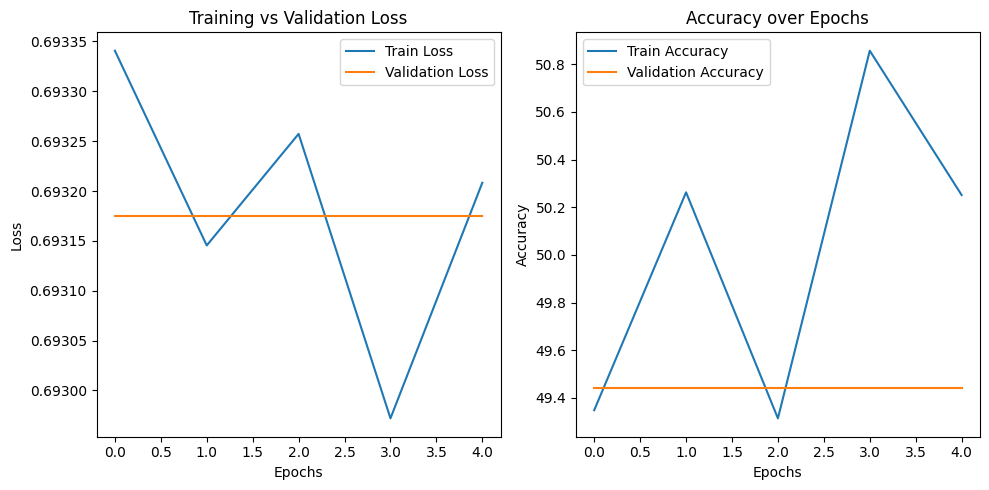

In [49]:
print("Improved Model Best Validation Acuuracy is: " , valAccuracyBestImproved)
plotMetrics(trainLossesBestImproved, valLossesBestImproved, trainAccuraciesBestImproved, valAccuraciesBestImproved, epochsBestImproved)

Test Loss: 0.6931, Test Accuracy: 0.5045
Precision: 0.5048, Recall: 0.9968, F1-score: 0.6702


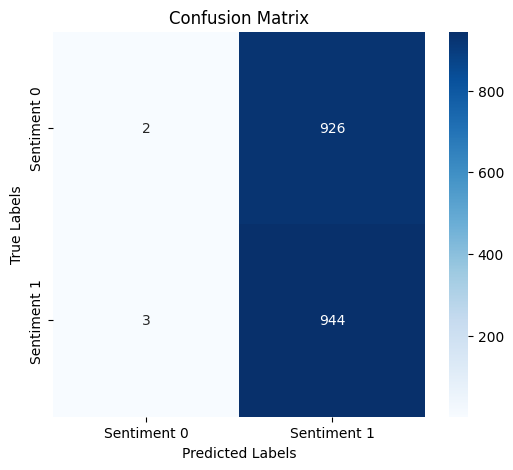

In [50]:
testAccuracyImproved, testPrecisionImproved, testRecallImproved, testF1Improved, testLossImproved, allLabelsImproved, allPredsImproved = evaluateModel(bestImprovedModel, testLoader, lossFn)
plotConfMatrix(allLabelsImproved, allPredsImproved)

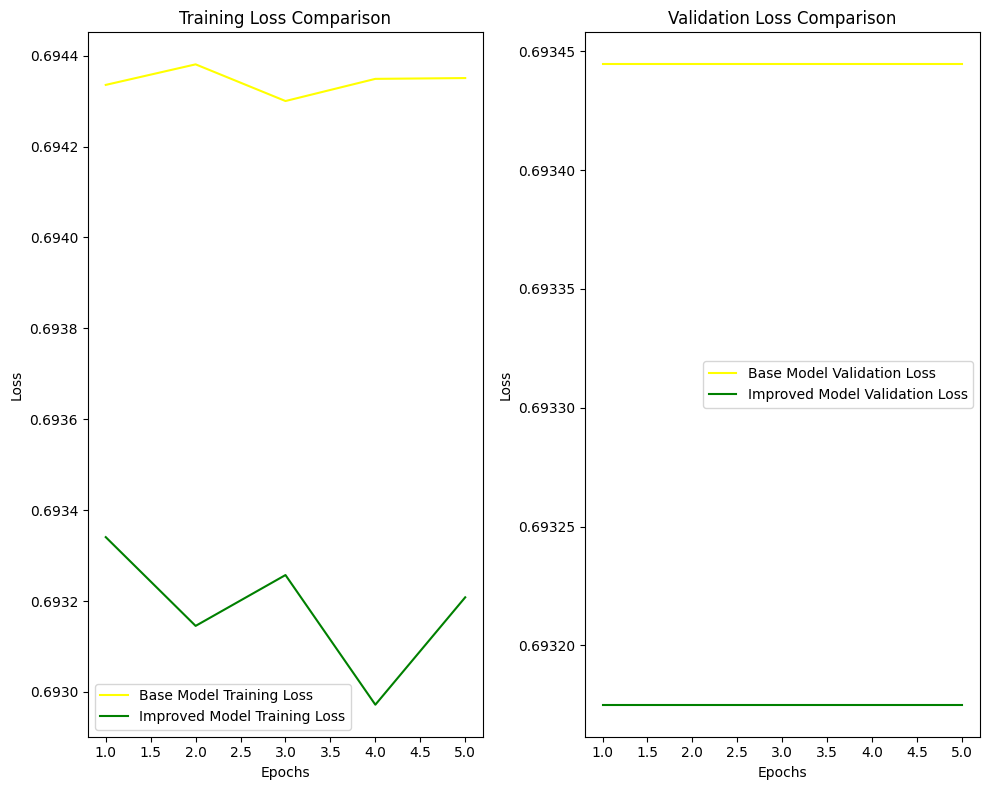

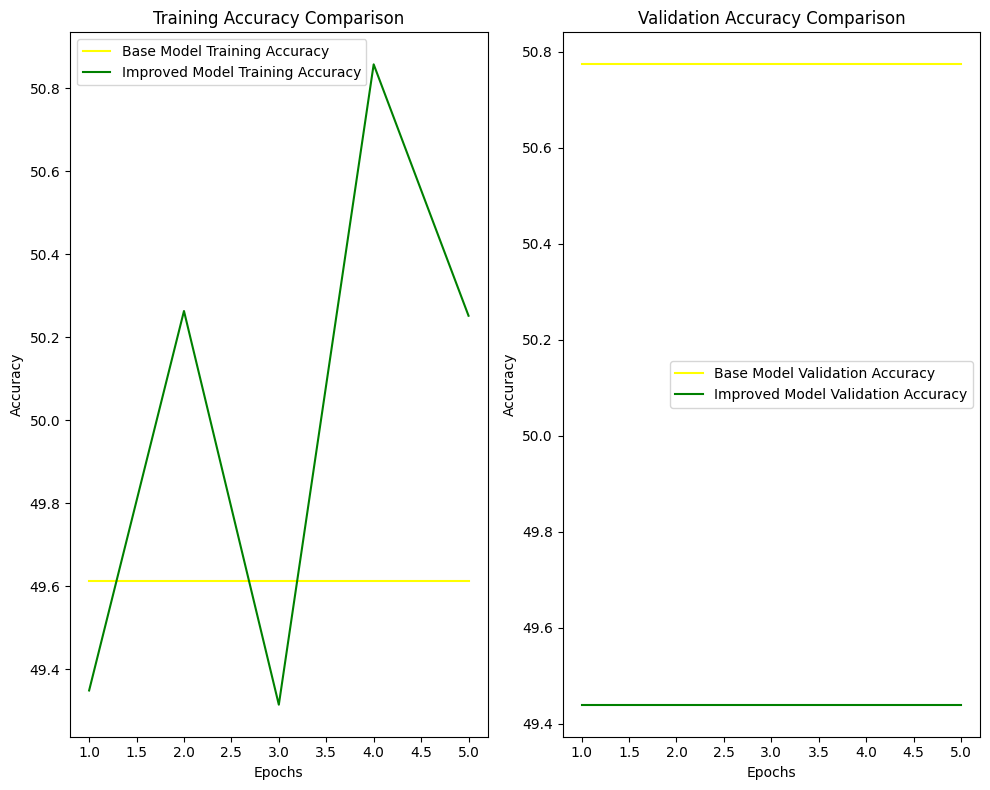

In [52]:
epochsRange = range(1, 6)

plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.plot(epochsRange, trainLossesBestBase, label='Base Model Training Loss', color='yellow')
plt.plot(epochsRange, trainLossesBestImproved, label='Improved Model Training Loss', color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochsRange, valLossesBestBase, label='Base Model Validation Loss', color='yellow')
plt.plot(epochsRange, valLossesBestImproved, label='Improved Model Validation Loss', color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss Comparison')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.plot(epochsRange, trainAccuraciesBestBase, label='Base Model Training Accuracy', color='yellow')
plt.plot(epochsRange, trainAccuraciesBestImproved, label='Improved Model Training Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Comparison')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochsRange, valAccuraciesBestBase, label='Base Model Validation Accuracy', color='yellow')
plt.plot(epochsRange, valAccuraciesBestImproved, label='Improved Model Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Comparison')
plt.legend()

plt.tight_layout()
plt.show()
